In [1]:
# Import required packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

pitches = pd.read_csv('/Users/JKovach/Downloads/mlb-pitch-data-20152018/pitches.csv')

# Reduce length by factor of 10 to increase performance, nan < 1% of values, drop nan
pitch_sample = pitches.sample(frac=.001, replace=True, random_state=0)
pitch_sample = pitch_sample.dropna(how='any')

#Numerical encoding for string type variables
num = LabelEncoder()
pitch_sample['n_pitch_type'] = num.fit_transform(pitch_sample['pitch_type'].astype('str'))
pitch_sample['n_type'] = num.fit_transform(pitch_sample['type'].astype('str'))
pitch_sample['n_code'] = num.fit_transform(pitch_sample['code'].astype('str'))
pitch_sample = pitch_sample.drop(['pitch_type', 'type', 'code'], 1)

pitch_sample.info()
# At this stage, GNB accuracy: 49.202%

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845 entries, 305711 to 722496
Data columns (total 40 columns):
px                 2845 non-null float64
pz                 2845 non-null float64
start_speed        2845 non-null float64
end_speed          2845 non-null float64
spin_rate          2845 non-null float64
spin_dir           2845 non-null float64
break_angle        2845 non-null float64
break_length       2845 non-null float64
break_y            2845 non-null float64
ax                 2845 non-null float64
ay                 2845 non-null float64
az                 2845 non-null float64
sz_bot             2845 non-null float64
sz_top             2845 non-null float64
type_confidence    2845 non-null float64
vx0                2845 non-null float64
vy0                2845 non-null float64
vz0                2845 non-null float64
x                  2845 non-null float64
x0                 2845 non-null float64
y                  2845 non-null float64
y0                 2845 n

In [2]:
# Identify low correlation features
pcor = pitch_sample.corr()
cor_target = abs(pcor['zone'])
relevant_features = cor_target[cor_target<0.01]
rf_pitch = pitch_sample[list(relevant_features.index)]
print(relevant_features)

# Drop irrelevant columns: 
# Dropping y0 as by value should always be 50
pitch_sample = pitch_sample.drop(['type_confidence', 'y0', 'event_num', 'b_score', 'on_1b', 'ab_id'],1)

# At this stage, GNB accuracy: 49.196%, slight drop attributed to reduction in features and dimensionality trade off

type_confidence    0.000693
y0                 0.003480
b_score            0.004652
outs               0.009654
pitch_num          0.006083
Name: zone, dtype: float64


Column Definitions - Column information from kaggle dataset (https://www.kaggle.com/pschale/mlb-pitch-data-20152018#pitches.csv), Columns with asterisks are defined by statcast definitions found at https://baseballsavant.mlb.com/csv-docs. Some definitions modified for clarity by me. Additional clarity can be found at https://trackman.zendesk.com/hc/en-us/articles/115002776647-Radar-Measurement-Glossary-of-Terms

1. px: x-location as pitch crosses the plate. X=0 means right down the middle
2. pz: z-location as pitch crosses the plate. Z=0 means the ground
3. start_speed: Speed of the pitch upon release by the pitcher (as it's thrown)
4. end_speed: Speed of the pitch when it crosses the front edge of the plate
5. spin_rate: The pitch's spin rate, measure in RPM
6. spin_dir: Direction in which pitch is spinning, measured in degrees (assuming 0 is the vector directly between the center of the mound and the center of home plate).
7. *break_angle: (None, deprecated from pre-statcast system, assuming 0 is vertical, angle of vector over break) 
8. *break_length: (None, deprecated from pre-statcast system, magnitude of break vector)
9. *break_y:
10. *ax: The acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet.
11. *ay: The acceleration of the pitch, in feet per second per second, in y-dimension, determined at y=50 feet.
12. *az: The acceleration of the pitch, in feet per second per second, in z-dimension, determined at y=50 feet.
13. *sz_bot: Bottom of the batter's strike zone set by the operator when the ball is halfway to the plate.
14. *sz_top: Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
15. type_confidence: Confidence in pitch_type classification. Goes up to 2 for some reason.
16. *vx0: The velocity of the pitch, in feet per second, in x-dimension, determined at y=50 feet.
17. *vy0: The velocity of the pitch, in feet per second, in y-dimension, determined at y=50 feet.
18. *vz0: The velocity of the pitch, in feet per second, in z-dimension, determined at y=50 feet.
19. x
20. x0
21. y
22. y0
23. z0
24. *pfx_x: Horizontal movement in feet from the catcher's perspective.
25. *pfx_z: Vertical movement in feet from the catcher's perspective.
26. nasty
27. *zone: Zone location of the ball when it crosses the plate from the catcher's perspective. 1-9 are in zone, left to right, then high to low. 11 is up and left of the zone, 12 is up and right of the zone, 13 and 14 are same for low
28. code: Records the result of the pitch. See dataset description for list of codes and their meaning
29. type: Simplified code, S (strike) B (ball) or X (in play)
30. pitch_type: Type of pitch. See dataset description for list of pitch types
31. event_num: event number, used for finding when exactly ejections happen.
32. b_score: score for the batter's team
33. ab_id: at-bat ID. Matches up with atbats.csv
34. b_count: balls in the current count
35. s_count: strikes in the current count
36. outsnumber of outs (before pitch is thrown)
37. pitch_num: pitch number (of at-bat)
38. on_1b: True if there's a runner on first, False if empty
39. on_2b: True if there's a runner on second, False if empty
40. on_3b: I don't know (/s. True if there's a runner on third, False if empty)

For: px
Number of outliers is: 22
Percentage of outliers is: 0.00773286467486819
For: pz
Number of outliers is: 63
Percentage of outliers is: 0.022144112478031636
For: start_speed
Number of outliers is: 20
Percentage of outliers is: 0.007029876977152899
For: end_speed
Number of outliers is: 30
Percentage of outliers is: 0.01054481546572935
For: spin_rate
Number of outliers is: 0
Percentage of outliers is: 0.0
For: spin_dir
Number of outliers is: 5
Percentage of outliers is: 0.0017574692442882249
For: break_angle
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_length
Number of outliers is: 75
Percentage of outliers is: 0.026362038664323375
For: break_y
Number of outliers is: 7
Percentage of outliers is: 0.002460456942003515
For: ax
Number of outliers is: 0
Percentage of outliers is: 0.0
For: ay
Number of outliers is: 7
Percentage of outliers is: 0.002460456942003515
For: az
Number of outliers is: 0
Percentage of outliers is: 0.0
For: sz_bot
Number of outliers is: 54
P

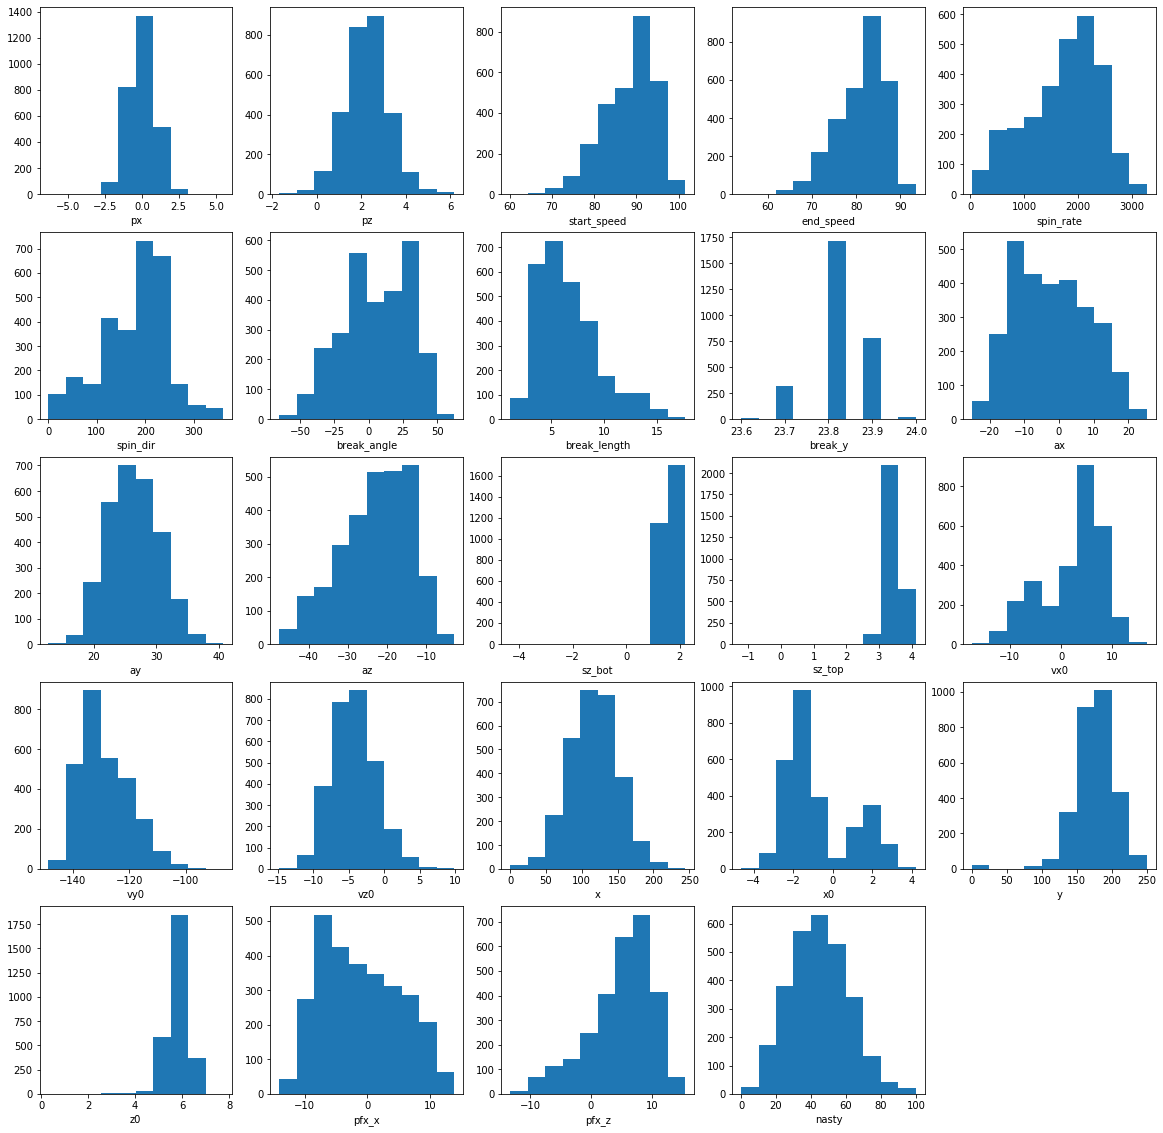

In [3]:
# split up the features which we'll treat as continuous vs categorical
cont_feat = ['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 
             'break_y', 'ax', 'ay', 'az', 'sz_bot', 'sz_top', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'z0', 'pfx_x', 
             'pfx_z', 'nasty']

# Check distributions and outliers
plt.figure(figsize=(20,20))
grid = 1

for var in cont_feat:
    plt.subplot(5,5,grid)
    plt.hist(pitch_sample[var])
    plt.xlabel(var)
    grid+=1
    
for var in cont_feat:   
    print("For: " + var)
    q75, q25 = np.percentile(pitch_sample[var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    ol = len(np.where((pitch_sample[var] > max_val) | (pitch_sample[var] < min_val))[0])
    print("Number of outliers is: {}".format(ol))
    print("Percentage of outliers is: {}".format(ol/pitch_sample.shape[0]))

For: px
Number of outliers is: 0
Percentage of outliers is: 0.0
For: pz
Number of outliers is: 57
Percentage of outliers is: 0.020191285866099893
For: start_speed
Number of outliers is: 0
Percentage of outliers is: 0.0
For: end_speed
Number of outliers is: 0
Percentage of outliers is: 0.0
For: spin_rate
Number of outliers is: 0
Percentage of outliers is: 0.0
For: spin_dir
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_angle
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_length
Number of outliers is: 59
Percentage of outliers is: 0.021238300935925127
For: break_y
Number of outliers is: 0
Percentage of outliers is: 0.0
For: ax
Number of outliers is: 0
Percentage of outliers is: 0.0
For: ay
Number of outliers is: 0
Percentage of outliers is: 0.0
For: az
Number of outliers is: 0
Percentage of outliers is: 0.0
For: sz_bot
Number of outliers is: 52
Percentage of outliers is: 0.0187929165160824
For: sz_top
Number of outliers is: 33
Percentage of outlier

/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,pz,break_length,sz_bot,sz_top,y,z0,pfx_z
count,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000
mean,2.254615,6.391159,1.564271,3.435675,176.219923,5.802584,5.215687
std,0.941782,2.732058,0.184070,0.226689,28.097044,0.423033,5.025180
min,-1.015000,1.100000,-4.341143,-1.224536,0.000000,3.019000,-13.280000
25%,1.654147,4.300000,1.490000,3.303587,161.452500,5.548273,2.471962
50%,2.262500,5.900000,1.573136,3.445076,177.030000,5.820175,6.096561
75%,2.837755,7.900000,1.660000,3.580000,193.610000,6.084652,9.004630
max,5.911000,16.800000,2.196187,4.135000,249.990000,7.079000,15.480000


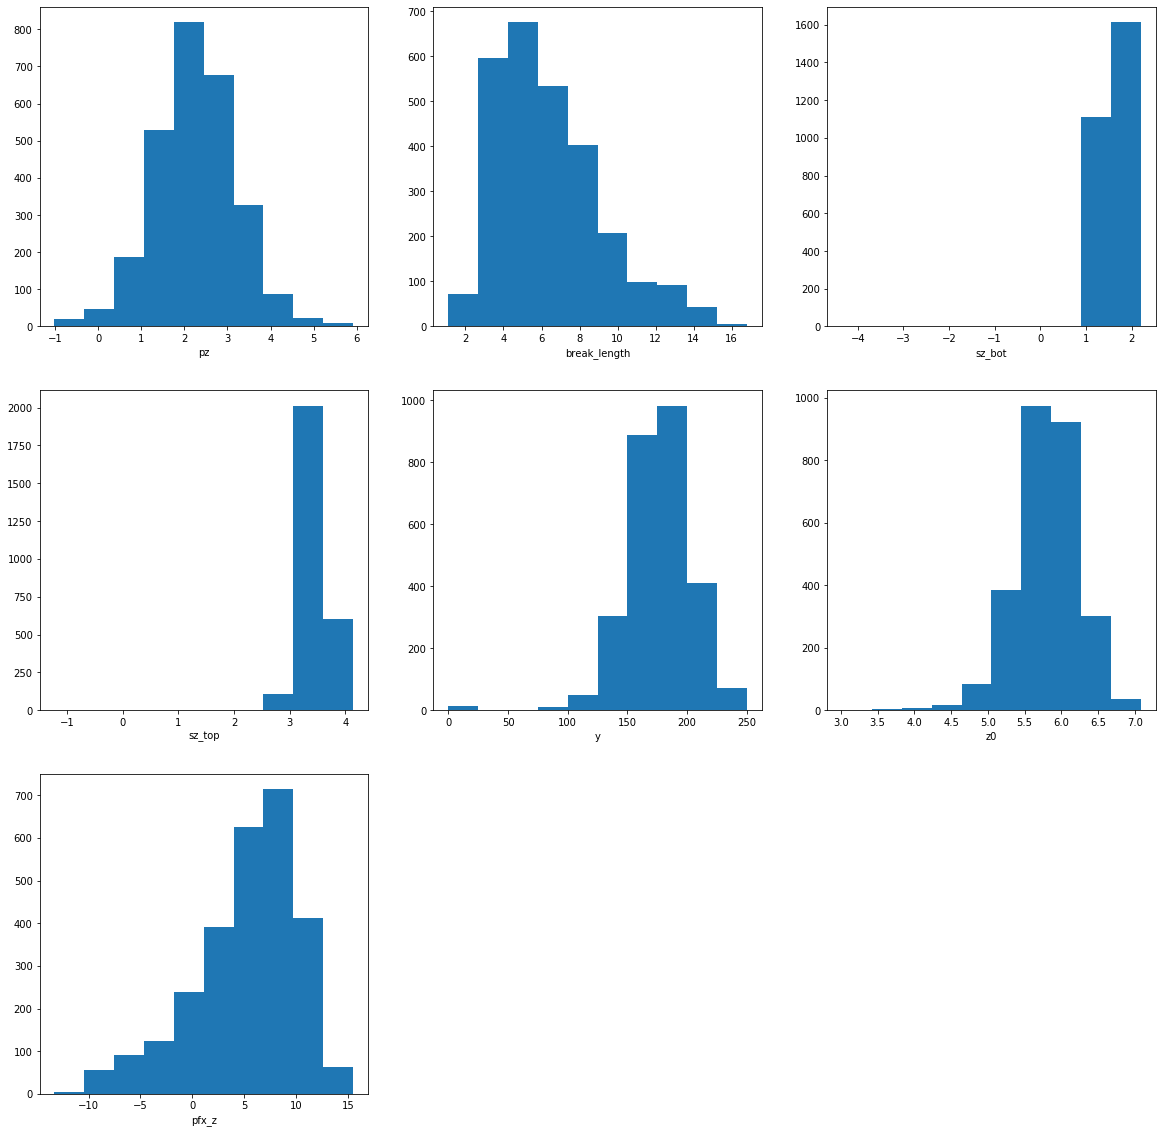

In [4]:
check = []

for var in cont_feat:
    print("For: " + var)
    q75, q25 = np.percentile(pitch_sample[var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    
    ol = len(np.where((pitch_sample[var] > max_val) | (pitch_sample[var] < min_val))[0])
    otl_perc = ol/pitch_sample.shape[0]
    
    if otl_perc < 0.01:
        pitch_sample = pitch_sample[pitch_sample[var]<max_val]
        pitch_sample = pitch_sample[pitches[var]>min_val]
        ol = len(np.where((pitch_sample[var] > max_val) | (pitch_sample[var] < min_val))[0])
        otl_perc = ol/pitch_sample.shape[0]
    
    else:
        check.append(var)
    
    print("Number of outliers is: {}".format(ol))
    print("Percentage of outliers is: {}".format(otl_perc))

plt.figure(figsize=(20,20))
grid = 1

for var in check:
    plt.subplot(3,3,grid)
    plt.hist(pitch_sample[var])
    plt.xlabel(var)
    grid+=1

ol_check = pitch_sample[check]
ol_check.describe()
# At this stage, GNB accuracy: 78.44%
# vy0 is not present in the remaining outlier columns. I believe that the previous iterations of the loop
# dropped enough concurrent outliers to drop the percentage of outliers in vy0 below 1%

For: pz
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_length
Number of outliers is: 0
Percentage of outliers is: 0.0
For: sz_bot
Number of outliers is: 0
Percentage of outliers is: 0.0
For: sz_top
Number of outliers is: 0
Percentage of outliers is: 0.0
For: y
Number of outliers is: 0
Percentage of outliers is: 0.0
For: z0
Number of outliers is: 0
Percentage of outliers is: 0.0
For: pfx_z
Number of outliers is: 0
Percentage of outliers is: 0.0


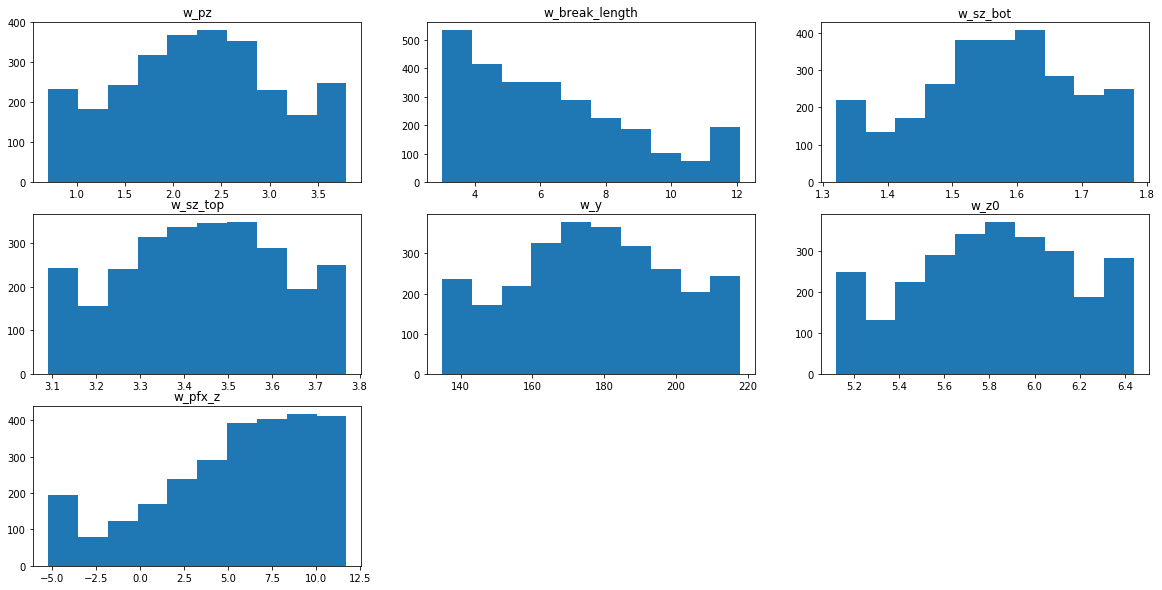

In [5]:
from scipy.stats.mstats import winsorize

plt.figure(figsize=(20,10))
grid = 1

for var in check:
    pitch_sample['w_' + var] = winsorize(pitch_sample[var],(0.05, 0.05))
    
    plt.subplot(3,3,grid)
    plt.hist(pitch_sample['w_' + var])
    plt.title('w_' + var)
    grid+=1
    
    print("For: " + var)
    q75, q25 = np.percentile(pitch_sample['w_' + var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    
    ol = len(np.where((pitch_sample['w_' + var] > max_val) | (pitch_sample['w_' + var] < min_val))[0])
    otl_perc = ol/pitch_sample.shape[0]
    print("Number of outliers is: {}".format(ol))
    print("Percentage of outliers is: {}".format(otl_perc))
    
    pitch_sample = pitch_sample.drop(var, 1)
# At this stage, GNB accuracy: 79.82%

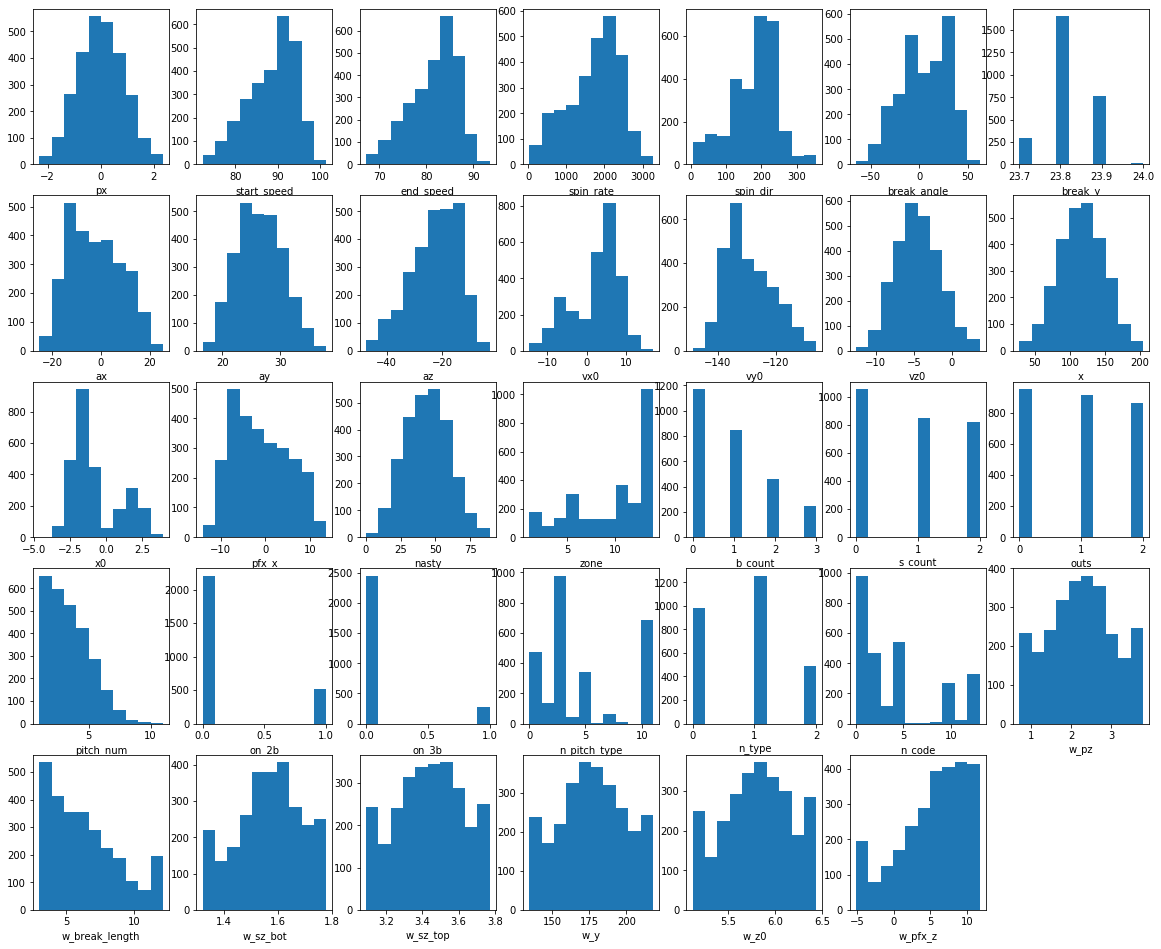

In [6]:
plt.figure(figsize=(20,20))
grid = 1

for var in list(pitch_sample.columns):
    
    plt.subplot(6,7,grid)
    plt.hist(pitch_sample[var])
    plt.xlabel(var)
    grid+=1

For: lt_start_speed
Jarque-Bera test statistics is 214.56166287160056 and p value is 0.0
Normality test statistics is 181.5709129336137 and p value is 3.735744961655697e-40
For: lt_end_speed
Jarque-Bera test statistics is 246.5792315343394 and p value is 0.0
Normality test statistics is 200.59576721460908 and p value is 2.7617388084815803e-44
For: lt_spin_rate
Jarque-Bera test statistics is 5239.686461219907 and p value is 0.0
Normality test statistics is 1142.4274028783323 and p value is 8.414755032047339e-249
For: lt_w_break_length
Jarque-Bera test statistics is 105.60239168194333 and p value is 0.0
Normality test statistics is 444.5582185644698 and p value is 2.9201784814238646e-97


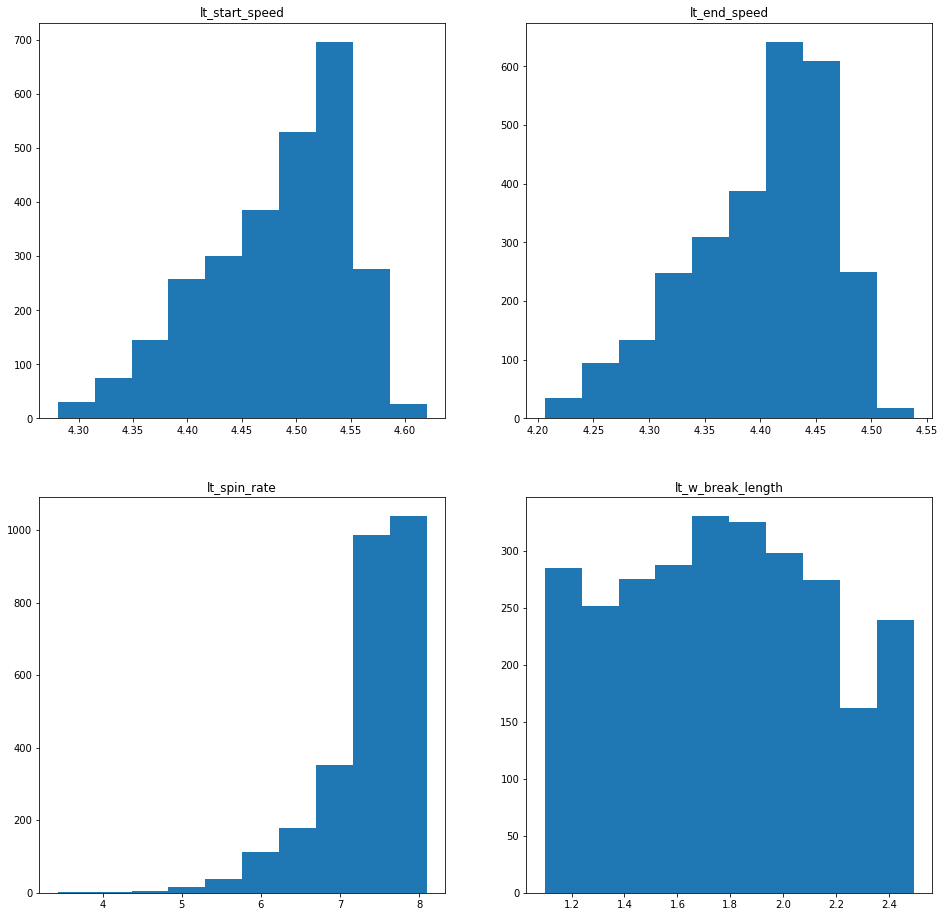

In [7]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

plt.figure(figsize=(16,16))
grid = 1
lt = ['start_speed', 'end_speed', 'spin_rate', 'w_break_length']

for var in lt:
    pitch_sample['lt_' + var] = np.log(pitch_sample[var])

    plt.subplot(2,2,grid)
    plt.hist(pitch_sample['lt_' + var])
    plt.title('lt_' + var)
    grid+=1

    print("For: lt_" + var)
    jb_stats = jarque_bera(np.sqrt(pitch_sample['lt_' + var]))
    norm_stats = normaltest(np.sqrt(pitch_sample['lt_' + var]))
    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

pitch_sample = pitch_sample.drop(['start_speed', 'end_speed', 'spin_rate', 'w_break_length'], 1)
# At this stage, GNB accuracy: 80.20%

For: bc_az_shift
Jarque-Bera test statistics is nan and p value is nan
Normality test statistics is nan and p value is nan
For: bc_vy0_shift
Jarque-Bera test statistics is 28.262094232532597 and p value is 7.293974050304186e-07
Normality test statistics is 27.555145988443325 and p value is 1.0386663804124785e-06
For: bc_x0_shift
Jarque-Bera test statistics is nan and p value is nan
Normality test statistics is nan and p value is nan
For: bc_pfx_x_shift
Jarque-Bera test statistics is 98.18475266893977 and p value is 0.0
Normality test statistics is 316.0870327725797 and p value is 2.3044799443023587e-69


/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


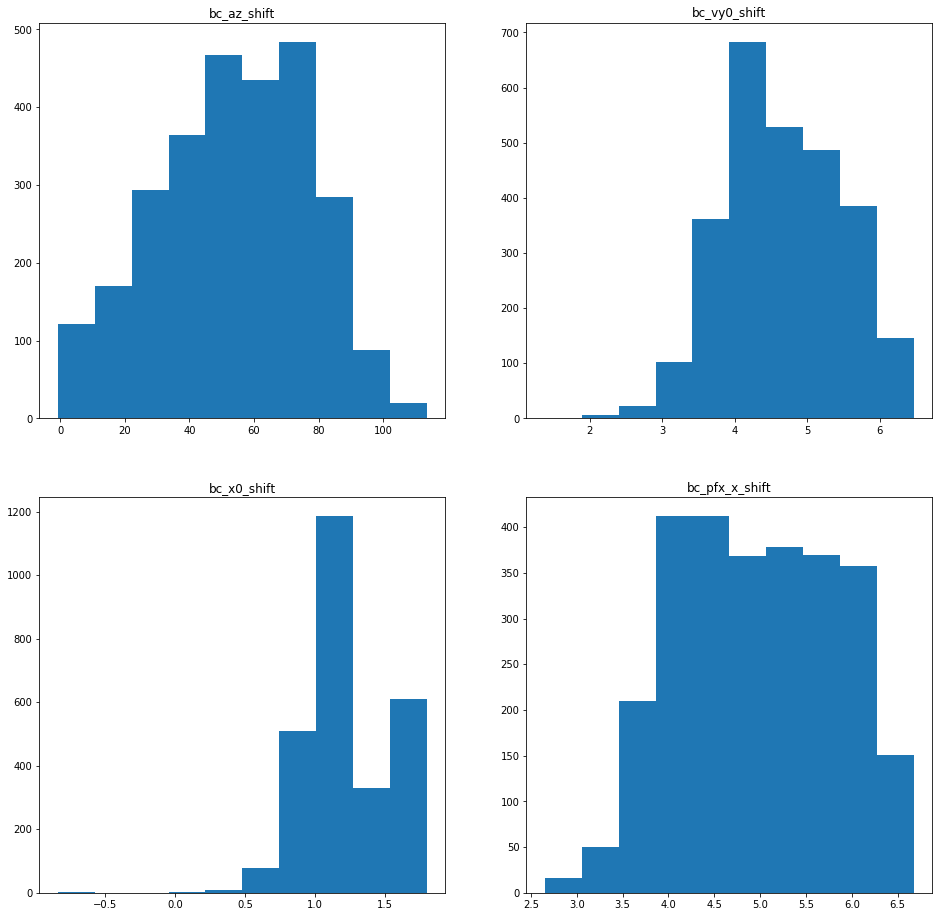

In [8]:
from scipy.stats import boxcox

plt.figure(figsize=(16,16))
grid = 1

def az_shift(num):
    return num + 47.549

def vy0_shift(num):
    return num + 151.990909

def x0_shift(num):
    return num + 5.097493

def pfx_x_shift(num):
    return num + 20.809519

def w_pfx_z_shift(num):
    return num + 4.97

pitch_sample['az_shift'] = pitch_sample['az'].apply(az_shift)
pitch_sample['vy0_shift'] = pitch_sample['vy0'].apply(vy0_shift)
pitch_sample['x0_shift'] = pitch_sample['x0'].apply(x0_shift)
pitch_sample['pfx_x_shift'] = pitch_sample['pfx_x'].apply(pfx_x_shift)

pitch_sample = pitch_sample.drop(['az', 'vy0', 'x0', 'pfx_x', 'w_pfx_z'],1)
shift = ['az_shift', 'vy0_shift', 'x0_shift', 'pfx_x_shift']

for var in shift:
    pitch_sample['bc_' + var] = boxcox(pitch_sample[var])[0]

    plt.subplot(2,2,grid)
    plt.hist(pitch_sample['bc_' + var])
    plt.title('bc_' + var)
    grid+=1

    print("For: bc_" + var)
    jb_stats = jarque_bera(np.sqrt(pitch_sample['bc_' + var]))
    norm_stats = normaltest(np.sqrt(pitch_sample['bc_' + var]))
    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

pitch_sample = pitch_sample.drop(['az_shift', 'vy0_shift', 'x0_shift', 'pfx_x_shift'], 1)
# At this stage, GNB accuracy: 80.99%

px                   0.168396
ay                   0.104480
vz0                  0.169885
x                    0.166938
nasty                0.129710
zone                 1.000000
n_type               0.459840
n_code               0.253296
w_pz                 0.411708
w_sz_bot             0.124860
w_y                  0.381447
lt_start_speed       0.131917
lt_end_speed         0.119433
lt_w_break_length    0.159949
bc_az_shift          0.132172
bc_vy0_shift         0.142833
Name: zone, dtype: float64


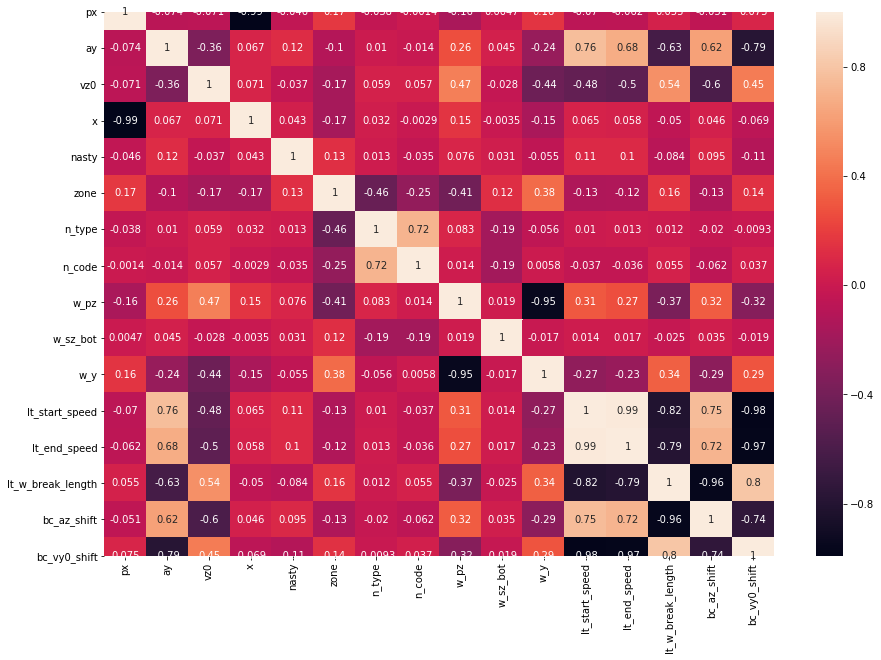

In [9]:
# Identify high correlation features
pcor = pitch_sample.corr()
cor_target = abs(pcor['zone'])
relevant_features = cor_target[cor_target>0.1]
rf_pitch = pitch_sample[list(relevant_features.index)]
print(relevant_features)

# Print Heatmap
plt.figure(figsize=(15,10))
rf_cor = rf_pitch.corr()
sns.heatmap(rf_cor, annot=True)
plt.show()

['px', 'ay', 'vz0', 'nasty', 'n_type', 'n_code', 'w_pz', 'w_sz_bot', 'lt_w_break_length', 'bc_vy0_shift']


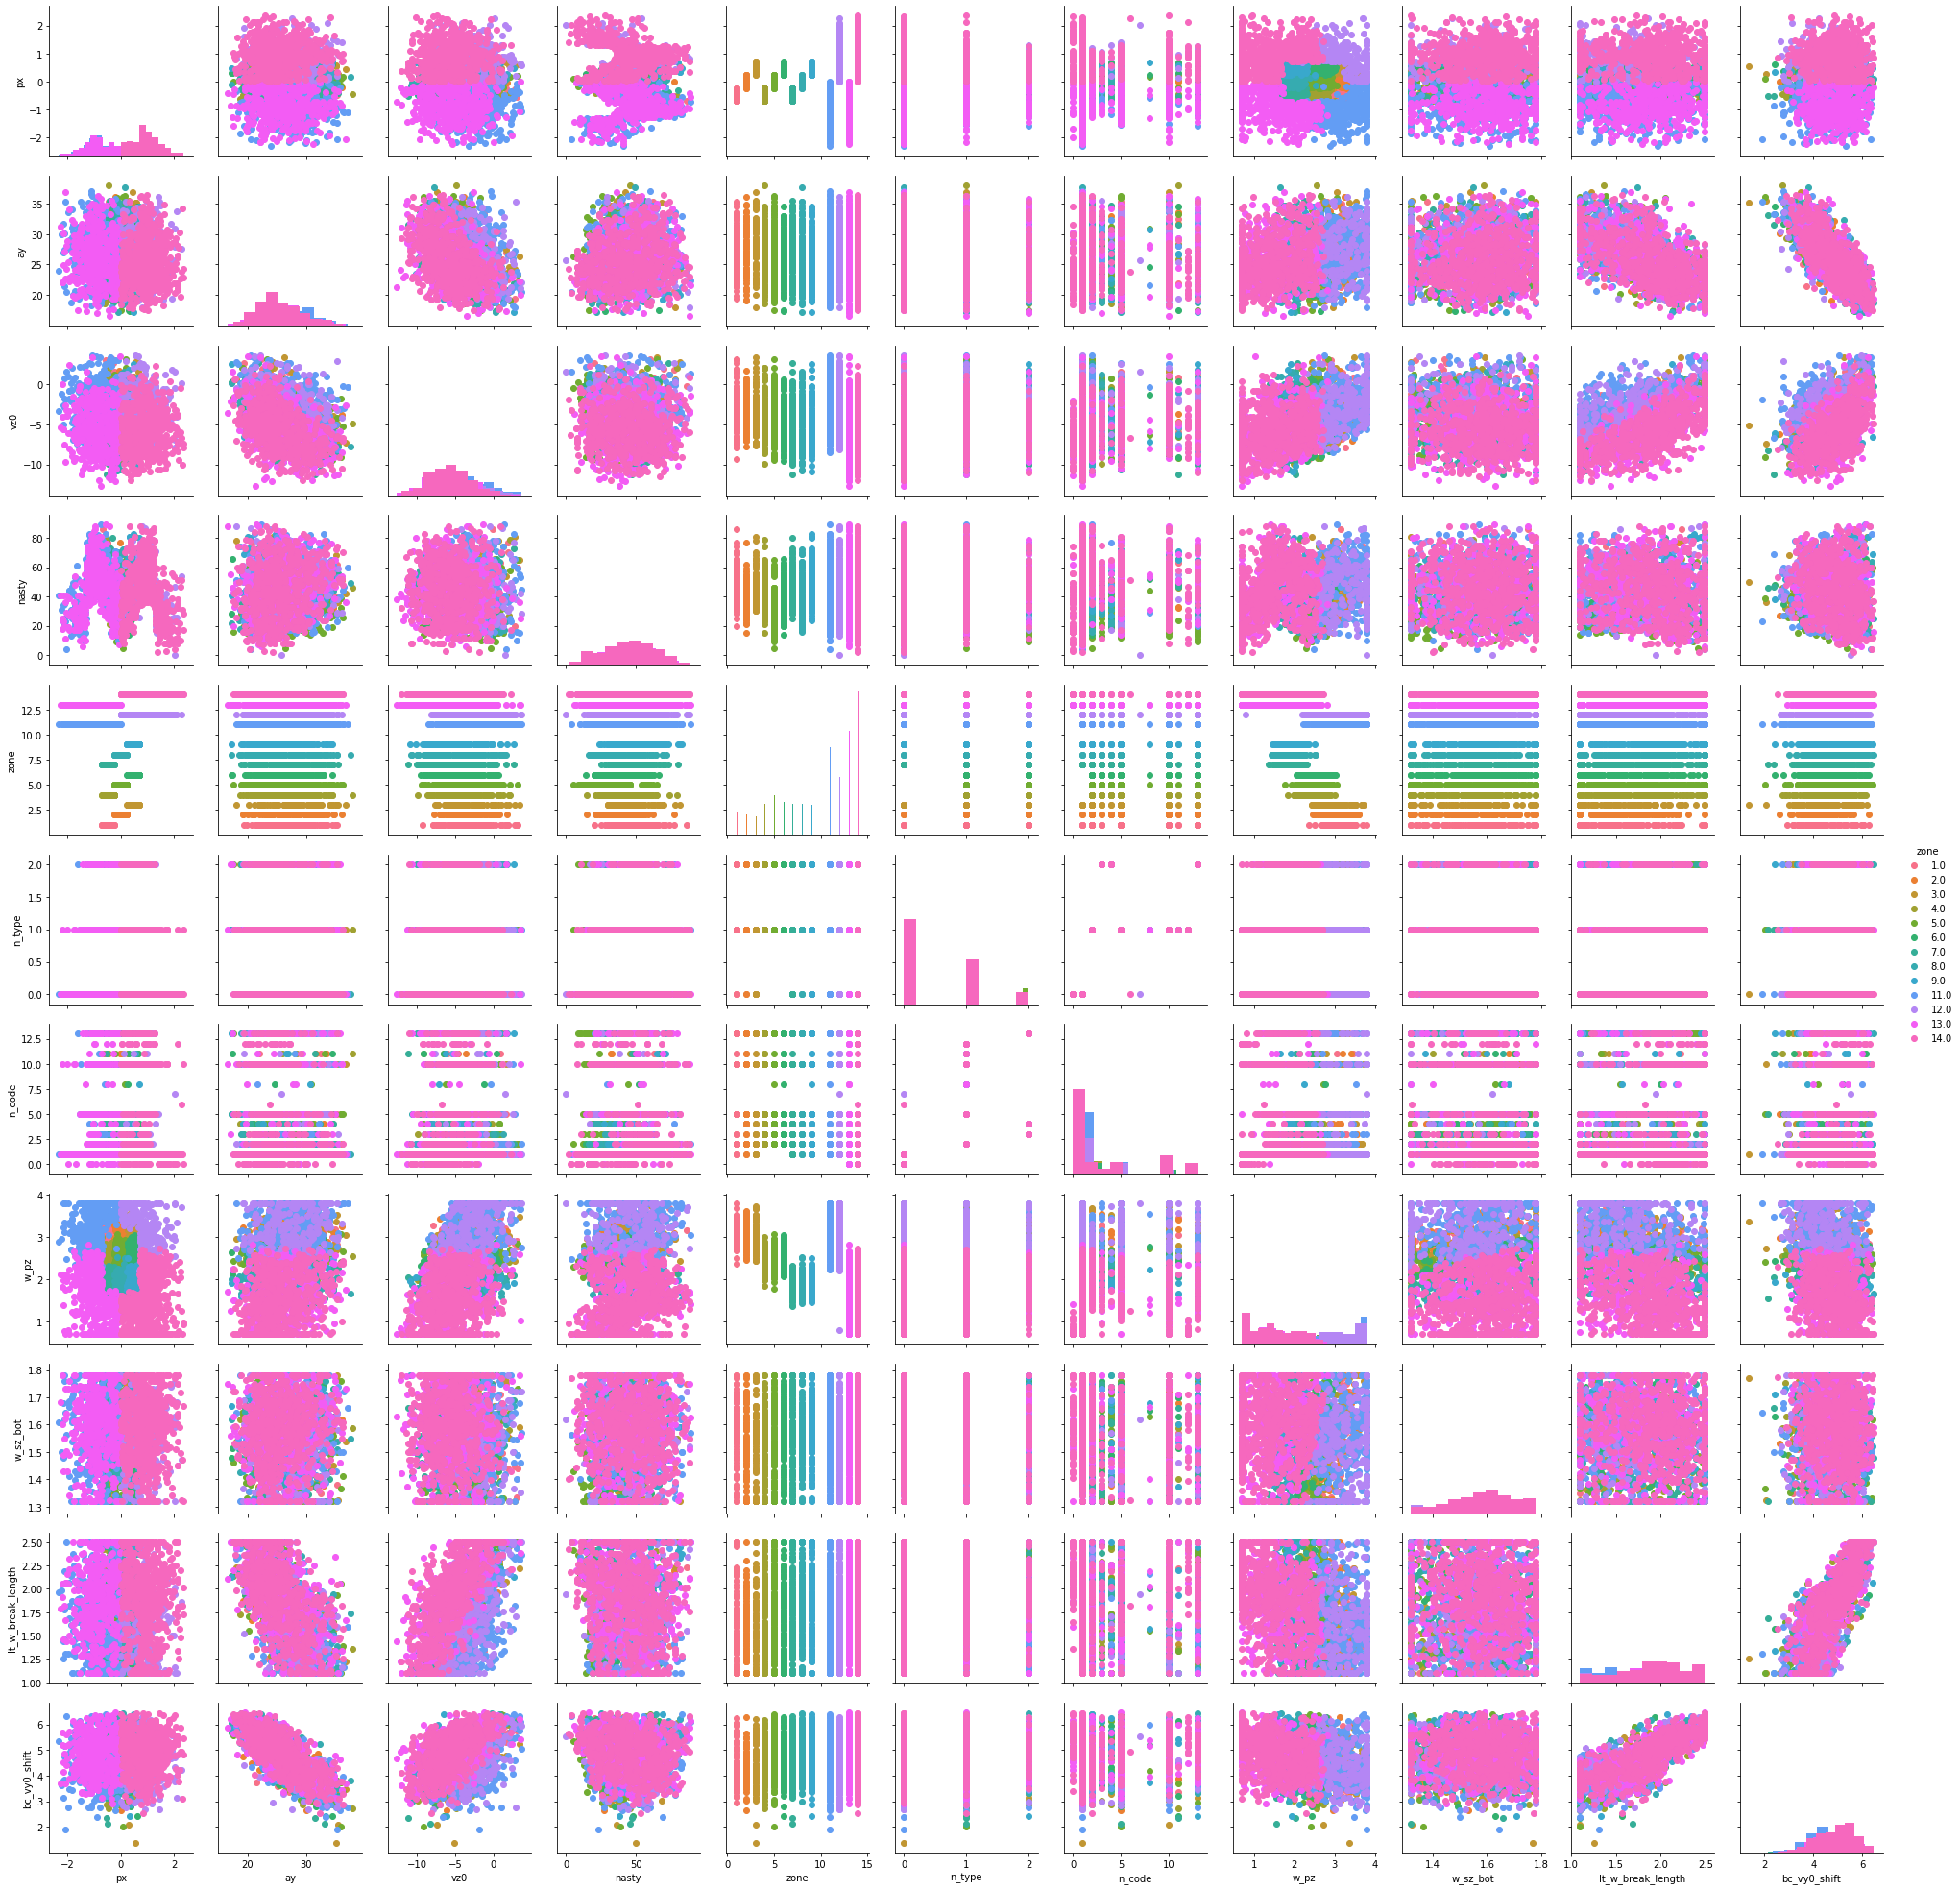

In [10]:
# Drop features with high intercorrelation
rf_pitch = rf_pitch.drop(['x', 'w_y', 'lt_start_speed', 'lt_end_speed', 'bc_az_shift'], 1)
rel_feat = list(rf_pitch.columns)
rel_feat.remove('zone')
print(rel_feat)

# Visualize multivariate relationships 
g = sns.PairGrid(rf_pitch, hue='zone')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
plt.show()
# At this stage, GNB accuracy: 80.99%

In [11]:
# Gaussian NB for Model #1
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

y = rf_pitch['zone']
X = rf_pitch.drop(['zone'],1)

gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)

print('Number of mislabeled points out of {}: {}'.format(
    X.shape[0],
    (y != y_pred).sum()
))
print('Accuracy Rate: {}'.format((X.shape[0] - (y != y_pred).sum())/X.shape[0]))

# Confusion Matrix
confusion_matrix(y, y_pred)

Number of mislabeled points out of 2726: 455
Accuracy Rate: 0.8330887747615554


array([[ 68,   4,   0,  11,   1,   0,   0,   0,   0,   9,   0,   0,   0],
       [  0,  57,   1,   2,  17,   1,   0,   0,   0,   7,   1,   0,   0],
       [  0,   3,  44,   0,   0,  16,   0,   0,   0,   0,  15,   0,   0],
       [  8,   2,   0, 105,   4,   0,   9,   0,   0,   0,   0,   3,   0],
       [  1,  16,   0,   4, 133,   1,   0,  10,   0,   0,   2,   0,   0],
       [  0,   0,  10,   0,   7, 112,   0,   0,   9,   0,   0,   0,   0],
       [  0,   0,   0,  15,   0,   0,  94,   5,   0,   0,   0,  15,   0],
       [  0,   0,   0,   0,   6,   0,   3, 114,   2,   0,   0,   1,   4],
       [  0,   0,   0,   0,   0,  11,   0,   3,  99,   0,   0,   0,  13],
       [ 15,   7,   0,   6,   1,   0,   0,   0,   0, 327,   0,  13,   0],
       [  0,  14,   8,   0,   0,   4,   0,   0,   1,   5, 197,   0,  13],
       [  0,   0,   0,   3,   0,   0,  20,  10,   0,  20,   0, 377,   6],
       [  0,   0,   0,   0,   0,   7,   0,  12,  22,   0,  15,   1, 544]])

In [16]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


# Check class imbalance
print(sorted(Counter(y).items()))

# Create random oversampling of data
ros = RandomOverSampler(random_state=0)
X_rs, y_rs = ros.fit_resample(X,y)

# Check class imbalance after oversampling
print(sorted(Counter(y_rs).items()))

X_tr, X_te, y_tr, y_te = train_test_split(X_rs, y_rs, test_size=.25, random_state=400)
print('Observations from training set {}'.format(X_tr.shape[0]))
print('Observations from test set {}'.format(X_te.shape[0]))

# Refit based on balanced training samples
gnb.fit(X_tr, y_tr)
y_te_pred = gnb.predict(X_te)

# Check model
print('Number of mislabeled points out of {}: {}'.format(
    X_te.shape[0],
    (y_te != y_te_pred).sum()
))    
print('Accuracy Rate: {}'.format((X_te.shape[0] - (y_te != y_te_pred).sum())/X_te.shape[0]))

# Confusion Matrix
print(confusion_matrix(y_te, y_te_pred))

# Check accuracy with test groups
print('Training R^2: ' + str(gnb.fit(X_tr, y_tr).score(X_tr, y_tr)))
print('Test R^2: ' + str(gnb.fit(X_te, y_te).score(X_te, y_te)))

[(1.0, 93), (2.0, 86), (3.0, 78), (4.0, 131), (5.0, 167), (6.0, 138), (7.0, 129), (8.0, 130), (9.0, 126), (11.0, 369), (12.0, 242), (13.0, 436), (14.0, 601)]
[(1.0, 601), (2.0, 601), (3.0, 601), (4.0, 601), (5.0, 601), (6.0, 601), (7.0, 601), (8.0, 601), (9.0, 601), (11.0, 601), (12.0, 601), (13.0, 601), (14.0, 601)]
Observations from training set 5859
Observations from test set 1954
Number of mislabeled points out of 1954: 361
Accuracy Rate: 0.8152507676560901
[[119   9   0   9   1   0   0   0   0   4   0   0   0]
 [  2 120   1   0  22   1   0   0   0   6   0   0   0]
 [  0  11 108   0   0  12   0   0   0   0  18   0   0]
 [  9   2   0 131   3   0  14   0   0   0   0   0   0]
 [  0  17   3   5 112   1   0  15   0   0   0   0   0]
 [  0   0   9   0   9 123   0   0  10   0   0   0   0]
 [  0   0   0  11   0   0 127   2   0   0   0   3   0]
 [  0   0   0   0  10   0   2 136   0   0   0   0   4]
 [  0   0   0   0   0  11   0   0 115   0   0   0   9]
 [ 16   6   0   6   0   0   0   0   0 1

In [19]:
from sklearn.neighbors import KNeighborsClassifier

nbrs = KNeighborsClassifier(n_neighbors=10, weights='distance')
X = rf_pitch[['n_type', 'w_pz']]
y = rf_pitch['zone']

Xrs, yrs = ros.fit_resample(X, y)
Xrs_train, Xrs_test, yrs_train, yrs_test = train_test_split(Xrs, yrs, test_size=0.25, random_state=400)
nbrs.fit(Xrs_train,yrs_train)

yrs_pred = nbrs.predict(Xrs_test)
print('Test Set Accuracy: {}'.format((Xrs_test.shape[0] - (yrs_test != yrs_pred).sum())/Xrs_test.shape[0]))
print('Training R^2: ' + str(gnb.fit(Xrs_train, yrs_train).score(Xrs_train, yrs_train)))
print('Test R^2: ' + str(gnb.fit(Xrs_test, yrs_test).score(Xrs_test, yrs_test)))

Test Set Accuracy: 0.8464687819856704
Training R^2: 0.3207031916709336
Test R^2: 0.34544524053224157


[0.14880202 0.26410256 0.19487179 0.17307692 0.18974359 0.2474359
 0.1525641  0.15       0.14615385 0.22307692]


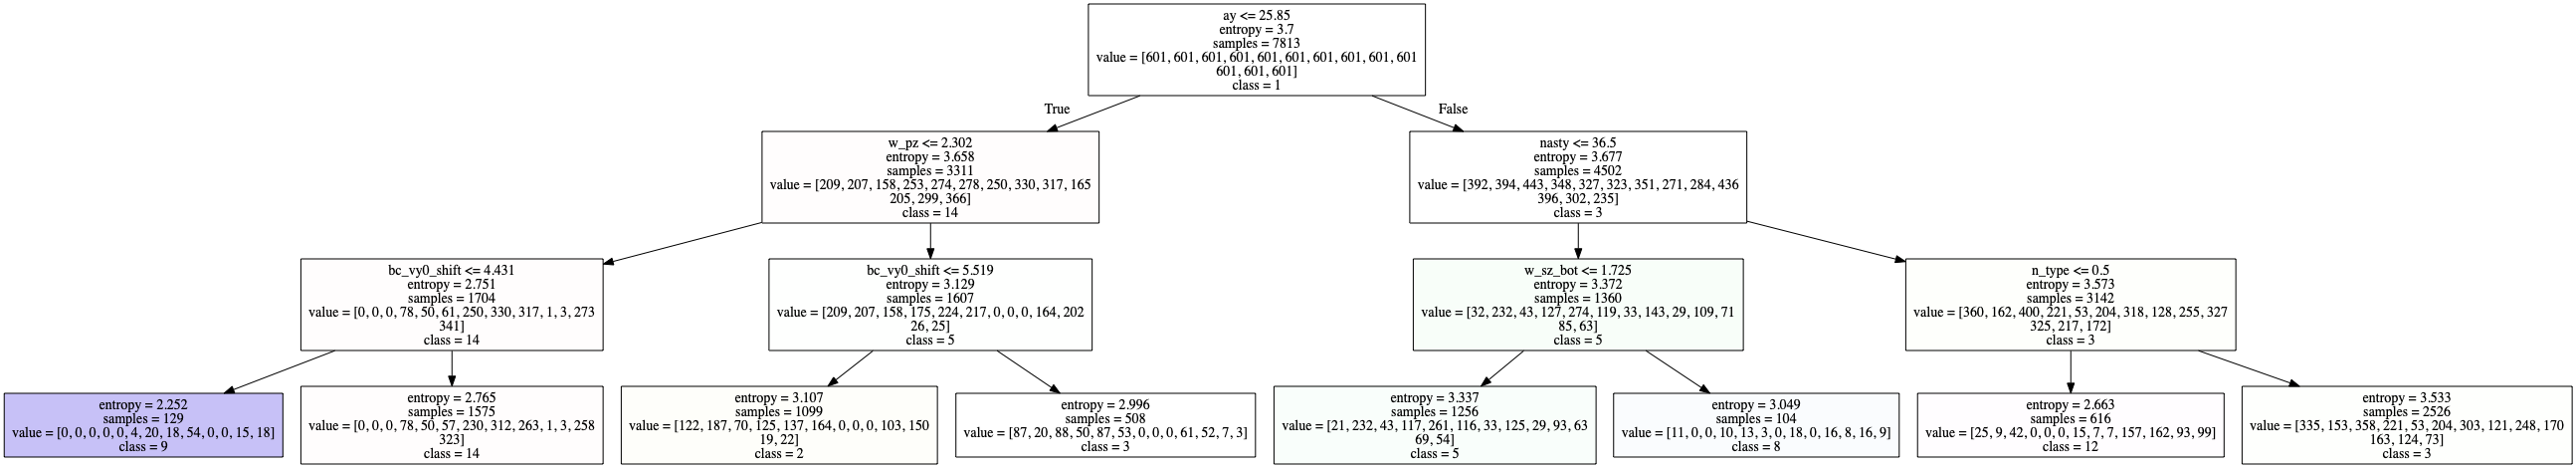

In [23]:
# Decision tree model
from sklearn import tree
from IPython.display import Image
import pydotplus, graphviz
from sklearn.model_selection import cross_val_score

# Reset features and target
X = rf_pitch.drop('zone', 1)
y = rf_pitch['zone']
X_rs, y_rs = ros.fit_resample(X,y)

# Using a simple decision tree to determine fastball or offspeed
pitch_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3,
)
pitch_tree.fit(X_rs, y_rs)

dot_data = tree.export_graphviz(
    pitch_tree, out_file=None,
    feature_names=X.columns,
    class_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '11', '12', '13', '14'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
print(cross_val_score(pitch_tree, X_rs, y_rs, cv=10))
Image(graph.create_png())
# Tree appears less accurate than simple NB

In [24]:
# Forest to predict fastball or offspeed
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X_rs, y_rs, cv=10)

/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jkovach/opt/a

array([0.97982346, 0.98461538, 0.98846154, 0.98461538, 0.98205128,
       0.98461538, 0.99487179, 0.98974359, 0.99615385, 0.99358974])

These models are reasonably accurate. They give us good explanatory power to demonstrate whether a pitch will be a fastball or offspeed pitch based on it's characteristics. There are two problems however; first, not all fastballs and offspeed pitches are the same. A curveball has different characteristics than a slider and a four-seam fastball generally has no break to it, where a two-seam fastball may. Secondly, these characteristics are only apparent after the pitch is thrown. This could be useful in scouting teams and players, specifically in determining what pitches a pitcher may have a proclivity toward throwing.

Because of these problems, they don't give us much in terms of predictive power, especially in terms of information that would be useful to a hitter. In order to maximize the usefulness of the model, we need to target a new dependent variable to determine the pitch type based on the situation (count, number of runners on, outs, etc.). With this new dependent, the model's primary usefulness would allow a batter to predict the most likely type of pitch being thrown in a given situation and correctly time their swing. Additionally, knowing what type of pitch a pitcher might throw, we could create additional models which could predict the continuous variable characteristics to expect of the pitch. 